<a href="https://colab.research.google.com/github/pongsantichai-piyachet-nalgo-intern/nalgo-intern-piyachet/blob/main/%E5%89%8D%E5%87%A6%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 1
CLASS = 2
EPOCH = 50
lr = 0.001

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
filepath = '/content/drive/MyDrive/dataset'
trainfilepath = filepath + '/train/'
testfilepath = filepath + '/test/_annotations.txt'
sample = '/content/drive/MyDrive/modified_annotations_train.txt'
train = '/content/drive/MyDrive/train/'

In [ ]:
def loadDataSet(dataPath):
    data = []
    file = open(dataPath, "r")
    content_list = file.readlines()
    for i in range(len(content_list)):
        txt = content_list[i]
        imglabel = txt.split()
        img = imglabel[0]
        label = int(imglabel[1])
        data.append([img,label])

    X = [] #image
    Y = [] #labels
    for img,l in data:
      X.append(img)
      Y.append(l)
    X = np.array(X)
    Y = np.array(Y).reshape(len(Y),1)

    return X,Y

In [ ]:
names,labels = loadDataSet(sample)

In [ ]:
def loadToImage(array):
    imagarray=[]
    imageSize = 64
    for filename in array:
        # print(train+filename)
        image = cv2.imread(train+filename,0)
        image = cv2.resize(image,(imageSize,imageSize))
        imagarray.append(image)
    return imagarray

In [ ]:
images = loadToImage(names)
images = np.array(images)

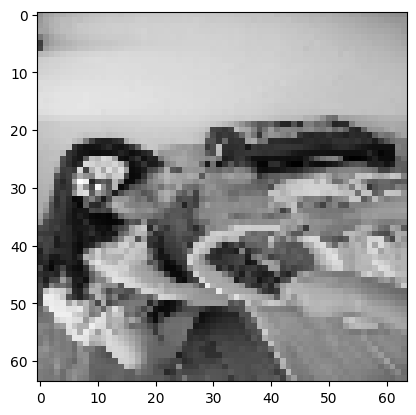

[1]


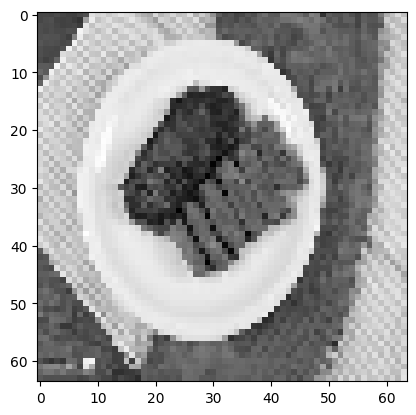

[0]


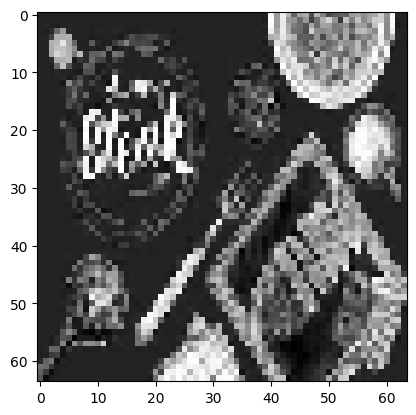

[0]


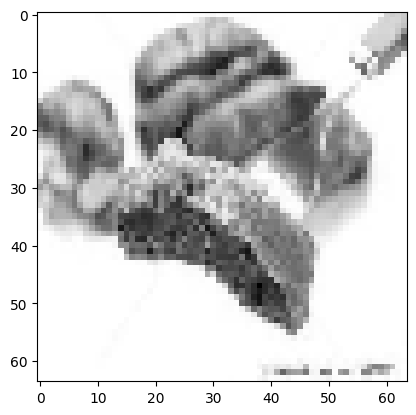

[0]


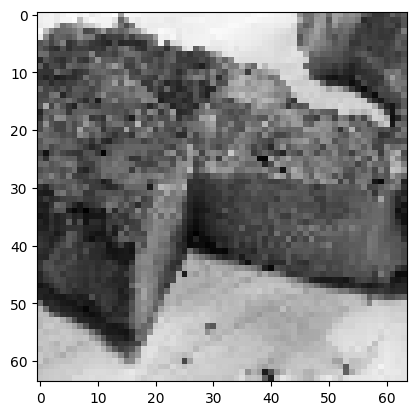

[0]


In [ ]:
for i in range(5):
    plt.imshow(images[i],cmap='gray')
    plt.show()
    print(labels[i])

In [ ]:
import torch
from torchvision import datasets
from torch.utils.data.dataset import Subset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

transform = T.Compose([T.Normalize(mean=[0.5], std=[0.5])])

images = images.astype(np.float32) / 255.0
images_tensor = torch.from_numpy(images).unsqueeze(-3)
labels_tensor = torch.from_numpy(labels).long()

# ラベルが適切な形状であることを確認
if len(labels_tensor.shape) > 1:
    labels_tensor = torch.argmax(labels_tensor, dim=1)  # マルチラベル形式の場合

class CustomDataset(Dataset):
  def __init__(self, images, labels, transform):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    print(image.shape)
    if self.transform:
      image = self.transform(image)

    return image, label

# カスタムデータセットを作成
datasets = CustomDataset(images_tensor, labels_tensor, transform=transform)

# データセットのサイズを取得
dataset_size = len(datasets)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# 訓練データ、検証データ、テストデータに分割
train_split = int(np.floor(0.8 * dataset_size))
train_indices = indices[:train_split]
test_indices = indices[train_split:]

train_dataset = Subset(datasets, train_indices)
test_dataset = Subset(datasets, test_indices)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self, class_num):
    super(Net, self).__init__()
    self.feature = nn.Sequential(
          # ブロック1
          nn.Conv2d(1, 32, kernel_size=3, padding=(1,1), padding_mode="replicate"),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, padding=(1,1), padding_mode="replicate"),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          nn.Dropout(0.25),

          # ブロック2
          nn.Conv2d(64, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          nn.Dropout(0.25)
    )
    self.classifier = nn.Sequential(
        nn.Linear(32768, 512),
        nn.Dropout(0.5),
        nn.Linear(512, class_num)

    )

  def forward(self, x):
    x = self.feature(x)
    x = x.view(x.size()[0], -1)
    #print(x.size())
    x = self.classifier(x)
    return x

In [ ]:
import torch.optim as optim

net = Net(class_num = CLASS)
net = net.to(device)
cel = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(EPOCH):

  # モデル学習
  train_loss_num = 0
  train_num = 0
  train_correct_num = 0

  for (inputs, labels) in train_loader:
    #print(labels.shape, inputs.shape)
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = cel(outputs, labels)
    loss.backward()
    optimizer.step()
    loss = cel(outputs, labels)
    train_loss_num += loss.item()
    _, predicted = outputs.max(1)
    train_num += labels.size(0)
    train_correct_num += (predicted == labels).sum().item()

  # 学習ごとの検証
  test_loss_num = 0
  test_num = 0
  test_correct_num = 0

  with torch.no_grad():
    for (inputs, labels) in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = cel(outputs, labels)
      test_loss_num += loss.item()
      _, predicted = outputs.max(1)
      test_num += labels.size(0)
      test_correct_num += (predicted == labels).sum().item()

  if epoch % 5 == 0:
    print(f"学習回数：{epoch}, train_loss値:{train_loss_num/train_num}, train_正解率：{train_correct_num/train_num},  test_loss値:{test_loss_num/test_num}, test_正解率：{test_correct_num/test_num}")

  train_loss_list.append(train_loss_num)
  train_acc_list.append(train_correct_num/train_num)
  test_loss_list.append(test_loss_num)
  test_acc_list.append(test_correct_num/test_num)

# 重みを保存する
model_path = 'model.pth'
torch.save(net.to("cpu").state_dict(), model_path)


学習回数：0, train_loss値:0.0012984140531755914, train_正解率：0.9981343283582089,  test_loss値:0.0, test_正解率：1.0
学習回数：5, train_loss値:0.0, train_正解率：1.0,  test_loss値:0.0, test_正解率：1.0
学習回数：10, train_loss値:0.0, train_正解率：1.0,  test_loss値:0.0, test_正解率：1.0
学習回数：15, train_loss値:0.0, train_正解率：1.0,  test_loss値:0.0, test_正解率：1.0
学習回数：20, train_loss値:0.0, train_正解率：1.0,  test_loss値:0.0, test_正解率：1.0
学習回数：25, train_loss値:0.0, train_正解率：1.0,  test_loss値:0.0, test_正解率：1.0


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6, 6))
plt.plot(range(EPOCH), test_loss_list)
plt.plot(range(EPOCH), train_loss_list, c="#00ff00")
plt.xlim(0, EPOCH)
plt.ylim(0, 1)
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.plot()

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(range(EPOCH), test_acc_list)
plt.plot(range(EPOCH), train_acc_list, c='#00ff00')
plt.xlim(0, EPOCH)
plt.ylim(0, 1.0)
plt.xlabel("EPOCH")
plt.ylabel("ACC")
plt.plot()